# Recap: тема, задачи и гипотеза исследования







Тема проекта:
> Автоматическое определение троллинга в текстах при помощи различных языковых моделей

Основная гипотеза:

---

> **модели лучше справятся с классификацией открытого (overt) троллинга, так как он содержит более явные языковые маркеры**

---

Основными задачами нашего проекта являлось:

*   Дополнить исходный датасет нейтральными примерами (без троллинга)
*   Посмотреть, как различные модели справятся с выявлением троллинга в текстах в целом, сравнить результаты разных моделей
*   Посмотреть, как модели справятся с определением типа троллинга, сравнить результаты с исследованием [Lee et al. 2022]. ??? будем ли мы такое делать в итоге
*   Проанализировать ошибки, чтобы проверить гипотезу


Для проведения исследования мы выбрали метод zero-shot: в обеих частях проекта классификация проводилась без дополнительного обучения. Для проекта мы выбрали две модели:
* RoBERTa: решение задачи классификации при помощи предсказания наиболее вероятного слова на месте маски в промпте
* Mistral: решение задачи классификации при помощи получения ответов от модели



# Дополнение исходного датасета

Для решения задачи автоматического определения наличия троллинга в тексте нам пришлось дополнять исходный датасет нейтральными примерами (т.е., примерами без троллинга), поскольку исходный датасет содержал только троллинг.

Мы отбирали примеры так же, как и в датасете с троллингом, состоящие из контекста -- часто, вопроса --  и ответа на этот вопрос (мы набирали примеры из вопросно-ответных датасетов, включающих в себя примеры текстов с различных форумов и в т.ч. реддита). Количество набранных в итоге примеров -- 600, но на практике мы использовали лишь 300 из них (поскольку иначе смешанный датасет получался слишком большим, и модель очень долго считала ответы)

Набранные нейтральные примеры при необходимости можно увидеть [здесь](https://docs.google.com/spreadsheets/d/1inZ-oUb90I_EdEmv7_qidC9BD0DX15PZP4t0WmqeZvQ/edit?gid=1395045770#gid=1395045770)

# Mask-prompting классификация типа троллинга (без учета контекста): roberta

В качестве первой модели мы использовали RoBERTa-large. Работа проводилась по следующим этапам:

* классификация через mask-промптинг (для каждого текста применялся шаблон с < mask >, затем модель предсказывала наиболее вероятные токены на ее месте)
* сбор и категоризация предсказаний
* оценка качества на тестовой выборке

In [ ]:
!pip install datasets sacremoses

### Создание датасета

In [ ]:
import pandas as pd
import json

with open("test (2).json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

print(df.head())

In [ ]:
from sacremoses import MosesDetokenizer

detokenizer = MosesDetokenizer().detokenize
texts = [detokenizer(elem.split()).lower() for elem in df['Troll']]
labels = [elem for elem in df['TrollL']]
for i in range(5):
    print(texts[i], labels[i])

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead

MODEL_NAME = "roberta-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelWithLMHead.from_pretrained(MODEL_NAME).to("cuda")

### Паттерн и классы слов

Для начала посмотрим, какие слова будет предлагать модель на месте < mask >. Придумаем характерные предложения:

In [ ]:
# сначала будет идти overt trolling, потом covert

trial = ["Imagine being this stupid and still using the internet",
         "Only idiots believe in vaccines. Enjoy your 5G mind control, bitch",
         "Did you learn English from a cereal box?",
         "Oh wow, another useless opinion from someone who’s clearly unemployed",
         "Keep crying, maybe someone will care",
         "You’re so brave for sharing such a wrong opinion publicly!",
         "I’d agree with you, but then we’d both be wrong",
         "Wow, you really did your ‘research’ on Wikipedia, huh?",
         "Your logic is… unique. Let’s leave it at that.",
         "It’s adorable how confident you are despite being clueless"]

In [ ]:
# PATTERN = "{0} This message has an intention of <mask>."
# PATTERN = "{0} This response <mask> people."
# PATTERN = "{0} If I've recieved this message I would be <mask>."
# PATTERN = "{0} A person who wrote this message was <mask>."
# PATTERN = "{0} А given message is an example of <mask> trolling."
PATTERN = "Analyze the following message and classify its trolling type based on these definitions: Overt trolling is direct aggression, insults, or obvious provocation. Covert trolling is hidden malice, sarcasm, or passive-aggressive language. Message: {0}. This message contains <mask>."

def format_with_pattern(tokenizer, pattern, text):
    augmented_text = pattern.format(text).replace("<mask>", tokenizer.mask_token)
    tokenization = tokenizer(augmented_text)["input_ids"]
    mask_index = tokenization.index(tokenizer.mask_token_id)
    return tokenization, mask_index

def score_with_model(tokenization, index, device="cuda"):
    tensor = torch.LongTensor([tokenization]).to(device)
    with torch.no_grad():
        model_output = model(tensor)
    logits = model_output.logits[0]
    log_probs = torch.log_softmax(logits[mask_index], dim=-1)
    return log_probs

In [ ]:
import torch
import numpy as np

for text in trial:
    print(text)
    tokenization, mask_index = format_with_pattern(tokenizer, PATTERN, text)
    log_probs = score_with_model(tokenization, mask_index)
    top_probs, top_indexes = torch.topk(log_probs, k=5, dim=-1)
    for log_prob, index in zip(top_probs, top_indexes):
        print(tokenizer.decode([index]), np.exp(log_prob.item()))
    print("")

Даже перебрав разные промпты, не удалось найти тот, который бы выдавал разные результаты для overt/covert троллинга.
Попробуем взять тексты из датасета, чтобы посмотреть, изменится ли что-то.

In [ ]:
trial_2 = ["you all are such babies about tank thursdays. not nearly as bad as everyone says.",
         "It's just internalized homophobia. Support queer liberation instead of queer assimilation. Systems of colonial, heteronormative white supremacy have nothing good to offer you unless you're the kind of rich Caucasian that has private jet money.",
         "You believe it would have been OK for your mom to have killed you since you were the victim of a rape?",
         "get him a ps5...he'll probably marry you",
         "I am sorry but this just seems petty, you and your wife have been married for several years but it seems to me you still haven't gotten over her ex.   Otherwise i don't see the point of ''guys my wife was married to Mark Carrano and she dumped him'' than it being a gotcha moment.",
         "Ya'll wanted something gay like Sora didn't you? Well I for one am thrilled to have a new cool looking female fighter, don't get much of those. Arms chick didn't count cause Arms is shit, goofy ass noodle arm flailing nonsense lol.",
         ]

In [ ]:
for text in trial_2:
    print(text)
    tokenization, mask_index = format_with_pattern(tokenizer, PATTERN, text)
    log_probs = score_with_model(tokenization, mask_index)
    top_probs, top_indexes = torch.topk(log_probs, k=5, dim=-1)
    for log_prob, index in zip(top_probs, top_indexes):
        print(tokenizer.decode([index]), np.exp(log_prob.item()))
    print("")

К сожалению, результат не изменился.
Возможно, такой метод не подходит для этой классификации.

# Mask-prompting детекция троллинга (без учета контекста): roberta

### Создание датасета

Для задачи детекции троллинга среди нейтральных текстов понадобится смешать собранный нами датасет с примерами троллинга:

In [ ]:
import pandas as pd
import json

with open("test (2).json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

print(df.head())

# df.to_csv("output.csv", index=False)

In [ ]:
df_neut = pd.read_csv('neut.csv')
contexts = [x for x in df_neut['context']]
responses = [x for x in df_neut['response']]
labels = [0 for x in range(len(contexts))]
neut = [[x, responses[pos], labels[pos], 0] for pos, x in enumerate(contexts[:300])]
print(df_neut.head())
print()
print(neut[:3])

In [ ]:
import random

def make_dataset(df, neut):
  titles = [x for x in df['Title']]
  bodies = [x for x in df['Post']]
  contexts = [x + ' ' + bodies[pos] for pos, x in enumerate(titles)]
  trolls = [x for x in df['Troll']]
  troll_labels = [x for x in df['TrollL']]
  labels = [1 for x in range(len(contexts))]
  dataset_tr = [[x, trolls[pos], labels[pos], troll_labels[pos]] for pos, x in enumerate(contexts[:300])]
  dataset = dataset_tr + neut

  return dataset


test = make_dataset(df, neut)
random.seed(67)
random.shuffle(test)

print(len(test))
for x in test[:10]:
  print(x)

print()
test_labels = [x[2] for x in test]
print(test_labels[:10])

О - нейтральные сообщения, 1 - троллинг.

In [ ]:
from sacremoses import MosesDetokenizer

detokenizer = MosesDetokenizer().detokenize
texts = [detokenizer(elem[1].split()).lower() for elem in test]
labels = [elem for elem in test_labels]
for i in range(10):
    print(texts[i], labels[i])

model и tokenizer останутся теми же.

In [ ]:
# from transformers import AutoTokenizer, AutoModelWithLMHead

# MODEL_NAME = "roberta-large"
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# model = AutoModelWithLMHead.from_pretrained(MODEL_NAME).to("cuda")

Придумаем фразы для проверки модели:

### Паттерн и классы слов

In [ ]:
# сначала будут идти 6 фраз с троллингом (3 с overt, 3 - с covert), потом 4 нейтральных фразы

trial = ["Only idiots believe in vaccines. Enjoy your 5G mind control, bitch",
         "Are you fucking stupid or just mentally retarded?",
         "You clearly dont care about your child if you vaccinate him. Jut so you wait he gets autism or somethin worse.",
         "Oh wow, another useless opinion from someone who’s clearly unemployed",
         "This is your 'research'? I've seen TikTok comments with better citations",
         "Great, another park while our roads look like Swiss cheese. Priorities much?",
         "I see your point about renewable energy costs. The 2023 MIT study actually shows solar prices dropped 30%",
         "Just to double-check: when you say ‘remote work doesn’t work,’ are you referring to productivity or team cohesion?",
         "For that GPU issue, try updating to driver version 546.33 - it fixed similar problems for others.",
         "The character development in Chapter 2 is brilliant! Though the dialogue on page 5 feels a bit rushed"]

In [ ]:
PATTERN = "{0} This message has an intention of <mask>."
# PATTERN = "{0} If I've recieved this message I would be <mask>."

In [ ]:
import torch
import numpy as np

for text in trial:
    print(text)
    tokenization, mask_index = format_with_pattern(tokenizer, PATTERN, text)
    log_probs = score_with_model(tokenization, mask_index)
    top_probs, top_indexes = torch.topk(log_probs, k=5, dim=-1)
    for log_prob, index in zip(top_probs, top_indexes):
        print(tokenizer.decode([index]), np.exp(log_prob.item()))
    print("")

Теперь метки различаются. Составим списки характерных слов, чтобы модель могла различать два класса.  

In [ ]:
trolling = ["violence", "abuse", "humor", "harm", "malice", "cruelty", "abuse", "trolling", "bullying", "harassment", "mockery", "change"]
neutral = ["truth", "accuracy", "reality", "clarity", "helping", "help", "updating", "improvement", "speaking", "love"]

def score_sentiment(log_probs, good_words, bad_words):
    good_indexes = [tokenizer(" "+word, add_special_tokens=False)["input_ids"][0] for word in good_words]
    bad_indexes = [tokenizer(" "+word, add_special_tokens=False)["input_ids"][0] for word in bad_words]
    return torch.logsumexp(log_probs[good_indexes], dim=-1)-torch.logsumexp(log_probs[good_indexes+bad_indexes], dim=-1)

for text in trial:
    tokenization, mask_index = format_with_pattern(tokenizer, PATTERN, text)
    log_probs = score_with_model(tokenization, mask_index)
    prob = score_sentiment(log_probs, good_words=neutral, bad_words=trolling)
    print(text, f"{100*np.exp(prob.item()):.2f}")

Модель хорошо справилась с этими примерами (ближе к 0 - троллинг, ближе к 1 - обычные сообщения). Только третье предложение с конца разобрано неправильно.

### Замер качества и метрик по классам

In [ ]:
def score_sentiment(log_probs, good_words, bad_words):
    good_indexes = [tokenizer(" "+word, add_special_tokens=False)["input_ids"][0] for word in good_words]
    bad_indexes = [tokenizer(" "+word, add_special_tokens=False)["input_ids"][0] for word in bad_words]
    return torch.logsumexp(log_probs[...,good_indexes], dim=-1)-torch.logsumexp(log_probs[...,good_indexes+bad_indexes], dim=-1)

def score_batch_with_model(input_ids, indexes, pad_index=0, good_words=None, bad_words=None, device="cuda"):
    if good_words is None:
        good_words = neutral
    if bad_words is None:
        bad_words = trolling
    L = max(len(x) for x in input_ids)
    input_ids = [elem + [pad_index] * (L-len(elem)) for elem in input_ids]
    tensor = torch.LongTensor(input_ids).to(device)
    with torch.no_grad():
        model_output = model(tensor)
    logits = model_output.logits[np.arange(len(input_ids)), indexes]
    all_log_probs = torch.log_softmax(logits, dim=-1)
    log_probs = score_sentiment(all_log_probs, good_words=good_words, bad_words=bad_words)
    return log_probs, all_log_probs

In [ ]:
from tqdm.auto import tqdm

BATCH_SIZE = 32

input_ids, indexes = [], []
for text in texts:
    tokenization, mask_index = format_with_pattern(tokenizer, PATTERN, text)
    input_ids.append(tokenization)
    indexes.append(mask_index)
log_probs = []
for start in tqdm(range(0, len(input_ids), BATCH_SIZE)):
    curr_input_ids = input_ids[start:start+BATCH_SIZE]
    curr_indexes = indexes[start:start+BATCH_SIZE]
    curr_log_probs, _ = score_batch_with_model(curr_input_ids, curr_indexes, pad_index=tokenizer.pad_token_id)
    log_probs.extend(curr_log_probs)
log_probs = np.array([x.item() for x in log_probs])

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

pred_labels = []
for i in log_probs:
  if  np.exp(i)>= 0.5:
    pred_labels.append(0)
  else:
    pred_labels.append(1)

print(pred_labels[1:10])

print(f"{100*accuracy_score(labels, pred_labels):.2f}")

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1'] #0 - нейтральные сообщения, 1 - троллинг
print(classification_report(labels, pred_labels, target_names=target_names))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels[:600], pred_labels)

plt.rcParams["figure.figsize"] = (4,4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral', 'trolling'])
disp.plot(cmap=plt.cm.YlGn)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
pred_labels = []
for i in log_probs:
  if  np.exp(i)>= 0.7: #поменяем значение с 0.5 на 0.7, чтобы сместить границу классов (больше примеров будет попадать в разряд троллинга)
    pred_labels.append(0)
  else:
    pred_labels.append(1)
print(pred_labels[1:10])
print(f"{100*accuracy_score(labels, pred_labels):.2f}")

In [ ]:
target_names = ['class 0', 'class 1'] #0 - нейтральные сообщения, 1 - троллинг
print(classification_report(labels, pred_labels, target_names=target_names))

In [ ]:
cm = confusion_matrix(labels[:600], pred_labels)

plt.rcParams["figure.figsize"] = (4,4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral', 'trolling'])
disp.plot(cmap=plt.cm.YlGn)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
pred_labels = []
for i in log_probs:
  if  np.exp(i)>= 0.3: #поменяем значение на 0.3 чтобы больше примеров попадало в разряд нейтральных
    pred_labels.append(0)
  else:
    pred_labels.append(1)
print(pred_labels[1:10])
print(f"{100*accuracy_score(labels, pred_labels):.2f}")

In [ ]:
target_names = ['class 0', 'class 1'] #0 - нейтральные сообщения, 1 - троллинг
print(classification_report(labels, pred_labels, target_names=target_names))

In [ ]:
cm = confusion_matrix(labels[:600], pred_labels)

plt.rcParams["figure.figsize"] = (4,4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral', 'trolling'])
disp.plot(cmap=plt.cm.YlGn)
plt.title('Confusion Matrix')
plt.show()

Результат немного улучшился, но это все равно не сильно лучше случайного распределения.

### Расширение списка слов за счет добавления предложений из датасета

Снова попробуем взять предложения из датасета, а не из головы:

In [ ]:
# сначала будут идти 6 фраз с троллингом (3 с overt, 3 - с covert), потом 4 нейтральных фразы

trial_2 = ["you all are such babies about tank thursdays. not nearly as bad as everyone says.",
         "It's just internalized homophobia. Support queer liberation instead of queer assimilation. Systems of colonial, heteronormative white supremacy have nothing good to offer you unless you're the kind of rich Caucasian that has private jet money.",
         "You believe it would have been OK for your mom to have killed you since you were the victim of a rape?",
         "get him a ps5...he'll probably marry you",
         "I am sorry but this just seems petty, you and your wife have been married for several years but it seems to me you still haven't gotten over her ex.   Otherwise i don't see the point of ''guys my wife was married to Mark Carrano and she dumped him'' than it being a gotcha moment.",
         "Ya'll wanted something gay like Sora didn't you? Well I for one am thrilled to have a new cool looking female fighter, don't get much of those. Arms chick didn't count cause Arms is shit, goofy ass noodle arm flailing nonsense lol.",
         "delete it then reboot, at grub choose recovery mode, then choose 'xfix'",
         "To get more data the radio needs to work harder, which takes more power. The radio is the second largest power consumer in your phone behind the screen, so if you're say streaming netflix you're killing your battery because you're asking the radio to do a ton of work and then using it to watch a movie.",
         "Most of the jobs in the health industry. Speech pathologist, occupational therapist, respiratory therapy, etc. You only really hear about doctors, nurses, pharmacists, and physio therapists.",
         "I personally have fallen in love with Shadow Fight 2 because of the variety of the weapons and the unique bosses. Also, any of the Infinity Blade games (if you’re willing to spend a few bucks to grab them)."]

In [ ]:
PATTERN = "{0} This message has an intention of <mask>."
# PATTERN = "{0} If I've recieved this message I would be <mask>."
# PATTERN = "{0} A person who wrote this message had <mask> intent."
# PATTERN = "{0} A person who wrote this message wanted to <mask>."

In [ ]:
for text in trial_2:
    print(text)
    tokenization, mask_index = format_with_pattern(tokenizer, PATTERN, text)
    log_probs = score_with_model(tokenization, mask_index)
    top_probs, top_indexes = torch.topk(log_probs, k=5, dim=-1)
    for log_prob, index in zip(top_probs, top_indexes):
        print(tokenizer.decode([index]), np.exp(log_prob.item()))
    print("")

Дополним список слов:

In [ ]:
trolling = ["violence", "abuse", "humor", "harm", "malice", "cruelty", "abuse", "trolling", "bullying",
            "harassment", "mockery", "change", "humour", "genocide", "violence", "spam", "deception",
            "revenge", "shock"]
neutral = ["truth", "accuracy", "reality", "clarity", "helping", "help", "updating", "improvement",
           "speaking", "love", "succeeding", "fixing", "listening", "urgency", "sorts", "education",
           "accuracy", "recommendation", "praise", "sharing"]

for text in trial_2:
    tokenization, mask_index = format_with_pattern(tokenizer, PATTERN, text)
    log_probs = score_with_model(tokenization, mask_index)
    prob = score_sentiment(log_probs, good_words=neutral, bad_words=trolling)
    print(text, f"{100*np.exp(prob.item()):.2f}")

Модель разобрала все примеры верно (если брать 50 за границу классов).

### Замер качества и метрик по классам

In [ ]:
from tqdm.auto import tqdm

BATCH_SIZE = 32

input_ids, indexes = [], []
for text in texts:
    tokenization, mask_index = format_with_pattern(tokenizer, PATTERN, text)
    input_ids.append(tokenization)
    indexes.append(mask_index)
log_probs = []
for start in tqdm(range(0, len(input_ids), BATCH_SIZE)):
    curr_input_ids = input_ids[start:start+BATCH_SIZE]
    curr_indexes = indexes[start:start+BATCH_SIZE]
    curr_log_probs, _ = score_batch_with_model(curr_input_ids, curr_indexes, pad_index=tokenizer.pad_token_id)
    log_probs.extend(curr_log_probs)
log_probs = np.array([x.item() for x in log_probs])

In [ ]:
pred_labels = []
for i in log_probs:
  if  np.exp(i)>= 0.5:
    pred_labels.append(0)
  else:
    pred_labels.append(1)

print(pred_labels[1:10])

print(f"{100*accuracy_score(labels, pred_labels):.2f}")

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1'] #0 - нейтральные сообщения, 1 - троллинг
print(classification_report(labels, pred_labels, target_names=target_names))

In [ ]:
cm = confusion_matrix(labels[:600], pred_labels)

plt.rcParams["figure.figsize"] = (4,4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral', 'trolling'])
disp.plot(cmap=plt.cm.YlGn)
plt.title('Confusion Matrix')
plt.show()

Здесь нет смысла двигать границу классов. Результат хоть и улучшился, но все еще плохой.

# Вывод
Для классификации overt/covert троллинга и в принципе его детекции без учета контекста не подходит метод mask-промптинга. Результат выходит чуть лучше случайного распределения. В теории, можно было бы подобрать больше промптов и выделить больше слов для категоризации, но вряд ли результат выйдет достаточно качественным.

# Zero-shot детекция троллинга: mistral

В качестве другой модели мы решили взять Mistral. Работа проводилась по следующим этапам:
* получение ответов от модели (запрашиваемый формат ответа: 1/0 - наличие vs. отсутствие троллинга) с помощью промпта
* оценка качества на сформированной тестовой выборке
* анализ ошибочных ответов, чтобы подтвердить/опровергнуть первоначальную гипотезу (см. выше)
* эксперименты по подбору промпта с целью улучшить качество классификации
* сравнение результатов с другими моделями и методами.

In [ ]:
!pip install --quiet -U mistralai

In [ ]:
# with open ("key.txt", "r") as fin:
#   api_key = fin.readline()

In [ ]:
from mistralai import Mistral

def run_mistral(user_message, api_key, model="mistral-large-latest"):
    client = Mistral(api_key=api_key)
    messages = [
        {"role": "user", "content": user_message}
    ]
    chat_response = client.chat.complete(
        model=model,
        messages=messages,
        # stop=["."]
    )
    return chat_response.choices[0].message.content

#### Подбор промпта и тестовые прогоны

Задаем первый промпт -- просим модель определить, есть ли в тексте троллинг и ответить в указанном формате

In [ ]:
PATTERN = "Identify if there is any trolling in the text, given after the word 'RESPONSE'. Base your decision on the context, given after the word 'CONTEXT'. CONTEXT: {0}, RESPONSE: {1}. Do not explain your decision, give only a number as an aswer, 1 if there is trolling in the text and 0 if there is not. "

In [ ]:
texts = [
    ["Why no achievements on PC? Does anyone else wish there was achievements on PC? Feels like there's not really anything to work for in this game outside of getting your tryhard on.",
    "Have you tried playing for fun?"],
    ["How would you prevent climate change? How would you prevent a climate change and potential extinction of humanity in a libertarian world?  (if you don't believe in climate change just pretend it's real)",
    "In a libertarian world, climate change would be addressed through property rights, market-based solutions like carbon pricing, technological innovation, and voluntary cooperation."],
    ["What are some good questions to ask my interviewer? I have an interview tomorrow. What questions would my interviewer like to hear?",
     "Save your time and stress and get another job honestly..they will stress you out. The only benefits you will like are spotify and Lyra...Food is not great and free university after working 2 years."]
]

In [ ]:
prompt_1 = PATTERN.format(texts[0][0], texts[0][1])
prompt_2 = PATTERN.format(texts[1][0], texts[1][1])

print(prompt_1)

Проверяем, что модель выдает то, что от нее просят

In [ ]:
response = run_mistral(prompt_1, api_key=api_key)
response_2 = run_mistral(prompt_2, api_key=api_key)
print(response)
print(response_2)

#### Создание датасета

Загружаем файлы с троллингом в датафрейм

In [ ]:
import pandas as pd
import json

with open("test (2).json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

print(df.head())

# df.to_csv("output.csv", index=False)

Загружаем нейтральный датасет в датафрейм (пока в отдельный)

In [ ]:
df_neut = pd.read_csv('neut.csv')
contexts = [x for x in df_neut['context']]
responses = [x for x in df_neut['response']]
labels = [0 for x in range(len(contexts))]
neut = [[x, responses[pos], labels[pos], 0] for pos, x in enumerate(contexts[:300])]
print(df_neut.head())
print()
print(neut[:3])

Объединяем нейтральный и троллинговый датафреймы, чтобы получить тестовую выборку, и перемешиваем в рандомном порядке, получаем итоговый тестовый датасет размеров в 600 примеров

In [ ]:
import random
# подмешиваю нейтральные примеры в тест + шаффлю чтобы сделать датасет

def make_dataset(df, neut):
  titles = [x for x in df['Title']]
  bodies = [x for x in df['Post']]
  contexts = [x + ' ' + bodies[pos] for pos, x in enumerate(titles)]
  trolls = [x for x in df['Troll']]
  troll_labels = [x for x in df['TrollL']]
  labels = [1 for x in range(len(contexts))]
  dataset_tr = [[x, trolls[pos], labels[pos], troll_labels[pos]] for pos, x in enumerate(contexts[:300])]
  dataset = dataset_tr + neut

  return dataset


test = make_dataset(df, neut)
random.seed(67)
random.shuffle(test)

print(len(test))
for x in test[:10]:
  print(x)

print()
test_labels = [x[2] for x in test]
print(test_labels[:10])

в датасет помимо текстов также включены:

x[2] (лейбл на 1-м месте после текстов) - метка наличия/отсутствия троллинга

x[3] (лейбл на 2-м месте после текстов) - метка типа троллинга (0 для нейтральных предложений). Нужна, чтобы потом посмотреть, что хуже определяется как троллинг, overt или covert

У мистрали есть лимит на количество запросов в минуту, поэтому тестировать приходится с использованием нескольких ключей, чтобы все успевало восстановиться и программа не вылетала

In [ ]:
# здесь я создаю словарь из ключей потому что в функции которая чередует ключи они берутся из словаря

api_keys = dict()
with open('keys.txt', 'r', encoding='utf-8') as f:
  for line in f:
    key, value = line.strip().split('+')
    if key not in api_keys:
      api_keys[key] = ''
    api_keys[key] = value

In [ ]:
import time

curr_global_key = "api_key1"

def get_model_response(message, api_keys, max_retries=15):
    global curr_global_key
    keys_list = list(api_keys.keys())
    for retry in range(max_retries):
        try:
            # print(f"Using API key: {curr_global_key}")
            time.sleep(1)
            response = run_mistral(message, api_keys[curr_global_key])
            # если запрос успешен, переключаемся на следующий ключ со следующим запросом
            curr_global_key = keys_list[(keys_list.index(curr_global_key) + 1) % len(keys_list)]
            return response
        except Exception as e:
            # если нет, то пробуем этот запрос с другим ключом
            if 'Requests rate limit exceeded' in str(e) or 'Status 429' in str(e):
                # print(f"Rate limit hit for {curr_global_key}, trying with next key after 1s...")
                time.sleep(1)
                curr_global_key = keys_list[(keys_list.index(curr_global_key) + 1) % len(keys_list)]
                continue
            else:
                raise e  # если ошибка не связана с лимитом, выбрасываем дальше
    raise Exception("Max retries reached")

#### Определение троллинга

Тестируем на датасете из 600 примеров пристегните ремни

In [ ]:
from tqdm import tqdm
import time

answers = []


for x in tqdm(test):
  time.sleep(1)
  prompt = PATTERN.format(x[0], x[1])
  response = get_model_response(prompt, api_keys=api_keys)
  answers.append(response)

print(answers[:10])
print(test_labels[:10])

P.S.: здесь собственно возникает ответ на вопрос, почему примеров 600, а не больше -- потому, что 600 примеров считаются по полчаса, иногда дольше, а ждать по часу+ на каждой итерации эксперимента совсем не хотелось 😭

Ответы модель дает в виде строк, перегоняем их в целые числа, чтобы сравнить с правильными

In [ ]:
# print(answers[:10])

for pos, x in enumerate(answers):
  answers[pos] = int(x)

print(answers[:10])
print(test_labels[:10])

#### Измерение качества

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

print(f"{100*accuracy_score(test_labels, answers):.2f}")

Как видно, с выявлением троллинга модель справляется довольно хорошо (и гораздо лучше, чем ROBERTA при попытке определения троллинга на основе fill-mask метода)

Посмотрим на метрики по классам:

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class neut', 'class troll']
print(classification_report(test_labels, answers, target_names=target_names))

#### Анализ ошибочных ответов

Напоминание: наша гипотеза состояла в следующем:

> С выявлением закрытого (covert) троллинга модель будет справляться хуже, чем с определением открытого.

Посчитаем процентное содержание предложений без троллинга, с открытым и с закрытым троллингом в ошибочных ответах модели, чтобы посмотреть, подтвердится ли гипотеза


In [ ]:
type_tr = []
for pos, x in enumerate(answers):
  if x != test_labels[pos]: # если ответ не правильный
    type_tr.append(test[pos][3]) # добавляем в список "ошибок" лейбл типа троллинга для примера,
                                 # на который дан неправильный ответ

# print(len(type_tr))
# print(type_tr[:5])
no_troll = type_tr.count(0)
overt_troll = type_tr.count(1)
covert_troll = type_tr.count(2)

res = {'Тип предложения': ['без троллинга', 'с открытым троллингом', 'с закрытым троллингом'],
       'Процент предложений данного типа в ошибочных ответах': [no_troll/len(type_tr)*100, overt_troll/len(type_tr)*100, covert_troll/len(type_tr)*100]}

df_res = pd.DataFrame(res)
df_res

In [ ]:
import matplotlib.pyplot as plt

labels = ['No trolling','Overt','Covert']
values = [no_troll/len(type_tr)*100, overt_troll/len(type_tr)*100, covert_troll/len(type_tr)*100]
colors = ['khaki','goldenrod','olive']

plt.figure(figsize=(3,4))
plt.rcParams['font.family'] = 'serif'
plt.pie(values,labels=labels,colors=colors)
plt.title('Распределение предложений в ошибочных ответах', fontsize=12, fontfamily='serif')
plt.axis('equal')
plt.show()

Как видно, гипотеза **подтвердилась**: среди ошибочных ответов действительно большинство примеров с закрытым типом троллинга

#### Попытка улучшить ситуацию с закрытым троллингом

Попробуем немного уточнить промпт и посмотреть, улучшится ли качество и уменьшится ли количество предложений с закрытым троллингом в ошибочных ответах

Промпты, которые мы пробовали:
1. *Identify if there is any trolling in the text, given after the word 'RESPONSE'. Trolling in the text may be explicit, which is direct insults or agression, or implicit, which is hidden malice or passive-agressive language. Base your decision on the context, given after the word 'CONTEXT'. CONTEXT: {0}, RESPONSE: {1}. Do not explain your decision, give only a number as an aswer, 1 if there is trolling in the text and 0 if there is not.* -- **не помогло**, хотя качество выросло (нейтрального и оверт класса в ошибках стало меньше, но при этом процент закрытого троллинга только увеличился)
2. *Classify the message given after the word 'RESPONSE' as either '1' (trolling) or '0' (not trolling), base your decision on context, given after the word 'CONTEXT'. Trolling (1) includes any intentional provocation: direct insults, shocking content (taboo topics), harmful disinformation, emotional manipulation, excessive criticism and discussion derailment (Digress). Not Trolling (0) is a neutral or constructive communication. CONTEXT: {0}, RESPONSE: {1}. Give only a number (0 or 1) as an answer* -- **совсем не помогло.**
3. *Identify if there is any trolling in the text, given after the word 'RESPONSE'. Note that trolling in the text can be implicit, which is hidden malice or passive-agressive language. Base your decision on the context, given after the word 'CONTEXT'. CONTEXT: {0}, RESPONSE: {1}. Do not explain your decision, give only a number as an aswer, 1 if there is trolling in the text and 0 if there is not* -- **помогло**

In [ ]:
PATTERN_1 = "Identify if there is any trolling in the text, given after the word 'RESPONSE'. Note that trolling in the text can be implicit, which is hidden malice or passive-agressive language. Base your decision on the context, given after the word 'CONTEXT'. CONTEXT: {0}, RESPONSE: {1}. Do not explain your decision, give only a number as an aswer, 1 if there is trolling in the text and 0 if there is not."

In [ ]:
from tqdm import tqdm
import time

answers = []


for x in tqdm(test):
  time.sleep(1)
  prompt = PATTERN_1.format(x[0], x[1])
  response = get_model_response(prompt, api_keys=api_keys)
  answers.append(response)

print(answers[:10])
print(test_labels[:10])

In [ ]:
# print(answers[:10])

for pos, x in enumerate(answers):
  answers[pos] = int(x)

print(answers[:10])
print(test_labels[:10])

In [ ]:
print(f"{100*accuracy_score(test_labels, answers):.2f}")

In [ ]:
target_names = ['class neut', 'class troll']
print(classification_report(test_labels, answers, target_names=target_names))

Как видим, качество повысилось на несколько процентов (81 vs 84). Посмотрим на распределение предложений в ошибочных ответах

In [ ]:
type_tr = []
for pos, x in enumerate(answers):
  if x != test_labels[pos]: # если ответ не правильный
    type_tr.append(test[pos][3]) # добавляем в список "ошибок" лейбл типа троллинга для примера,
                                 # на который дан неправильный ответ

print(len(type_tr))
# print(type_tr[:5])
no_troll = type_tr.count(0)
overt_troll = type_tr.count(1)
covert_troll = type_tr.count(2)

res = {'Тип предложения': ['без троллинга', 'с открытым троллингом', 'с закрытым троллингом'],
       'Процент предложений данного типа в ошибочных ответах': [no_troll/len(type_tr)*100, overt_troll/len(type_tr)*100, covert_troll/len(type_tr)*100]}

df_res = pd.DataFrame(res)
df_res

In [ ]:
labels = ['No trolling','Overt','Covert']
values = [no_troll/len(type_tr)*100, overt_troll/len(type_tr)*100, covert_troll/len(type_tr)*100]
colors = ['khaki','goldenrod','olive']

plt.figure(figsize=(3,4))
plt.rcParams['font.family'] = 'serif'
plt.pie(values,labels=labels,colors=colors)
plt.title('Распределение предложений в ошибочных ответах', fontsize=12, fontfamily='serif')
plt.axis('equal')
plt.show()

Как видно, **качество улучшилось и процент скрытого троллинга в ошибках снизился** (на 20%). При этом, впрочем, модель по-прежнему лучше всего справляется с классификацией открытого троллинга: его в ошибках меньше всего.


# Zero-shot классификация типа троллинга (overt/covert): mistral

Теперь посмотрим, как Мистраль будет справляться с определением типа троллинга в тексте

#### Создание датасета

In [ ]:
import pandas as pd
import json

with open("test (2).json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

print(df.head())

# df.to_csv("output.csv", index=False)

В данном случае датасет создаем только из примеров с троллингом и меток типа троллинга.

❗**Важно**: сама классификация троллинга тоже проводилась на датасете размером в **600** примеров! В ячейке значение 100 осталось после экспериментов с промптами из следующего раздела (они проводились на меньшем объеме, чтобы не ждать ответов слишком долго, и на полном датасете мы их не тестировали, потому что, забегая вперед, ничего не помогло).

In [ ]:
# новая функция для лепки датасета

def make_dataset(df):
  titles = [x for x in df['Title']]
  bodies = [x for x in df['Post']]
  contexts = [x + ' ' + bodies[pos] for pos, x in enumerate(titles)]
  trolls = [x for x in df['Troll']]
  labels = [x for x in df['TrollL']]
  dataset = [[x, trolls[pos]] for pos, x in enumerate(contexts[:100])]

  return dataset, labels

test, test_labels = make_dataset(df)

print(len(test))
for x in test[:5]:
  print(x)

print(test_labels[:5])

#### Подбор промпта

Промпты, которые мы тестировали:


1. Identify the type of trolling -- overt or covert -- in the text, given after the word 'RESPONSE'. Base your decision on the context, given after the word 'CONTEXT'. CONTEXT: {0}, RESPONSE: {1}. Do not explain your decision, give only a number as an answer, 1 if the trolling in the text is overt and 2 if it is covert. -- **64%** на 600 примерах
2. Identify the type of trolling in the text, given after the word 'RESPONSE'. Choose from two classes -- overt or covert trolling. Overt trolling might include more explicit insults or rudeness, whereas covert trolling is more hidden. Base your decision on the context, given after the word 'CONTEXT'. CONTEXT: {0}, RESPONSE: {1}. Do not explain your decision, give only a number as an answer, 1 if the trolling in the text is overt and 2 if it is covert. -- **68%** на 600 примерах

In [ ]:
PATTERN = "Identify the type of trolling in the text, given after the word 'RESPONSE'. Choose from two classes -- overt or covert trolling. Overt trolling might include more explicit insults or rudeness, whereas covert trolling is more hidden. Base your decision on the context, given after the word 'CONTEXT'. CONTEXT: {0}, RESPONSE: {1}. Do NOT explain your decision, give only a number as an answer, 1 if the trolling in the text is overt and 2 if it is covert. "

In [ ]:
texts = [
    ["Planning on leaving an envelope with some cash for our mail carrier in our mailbox today. With a note that it's for them. Is that the best way to do it?", 'Why the hell would you give em money? They get paid from tax payers since they are government screw em.'],
['Tips on arm hypertrophy? I’m 21M 5’7” 145lbs and I have skinny arms. Originally I focused on strength, but I’m trying to get some hypertrophy and it doesn’t seem to be working.        I can do 3x5 50lbs weighted pull-ups and dips, but I still feel like I have stick arms. My chest and back have definitely improved, but not arms.        What are some good exercises and tips for arm hypertrophy? Thanks!', 'The simplest was to get bigger arms fast is high-rep, relatively low weight work.   Try doing sets of 50 bicep curls, with a light weight- so that you arms should be burning like hell at the end of the 50. And do a good number of those sets (like 8). These are also very good for developing forearms.  Triceps add a lot to the size of the arms. The most effective, high rep exercise for triceps is sphinx push ups. Try doing 6 sets of 50 of those.'],
['Tip for everyone who is trying to shift: Do not shift when you’re in a bad/sad mood. I’m talking from personal experience when I say that when you’re angry or sad the shifting is way harder, just try to shift in happy moods and when you’re sad or angry you might be tired and it’s your mind telling you to take a break', 'Another tip: you can’t fucking shift realities'],
['My boyfriend made me turn around to look at my butt, then said I have “craters” all over the place. He went on to suggest I start doing squats before bed. This really hurt my feelings and made me feel disgusting. How would you guys react in this situation?', 'i don’t think he went about it the right way, but i think having preference and knowing what you find attractive and unattractive is okay. i don’t think he’s a piece of shit for wanting a SO who is in shape.'],
['Second pregnancy. When breast feeding, I go from some tiny triple A boobs up to a 32J. I\'m in the in-between stage. Is there anything that would fit now and later too? I\'m specifically looking for "sexy lingerie" so that very much limits my options.', 'That’s what the calculator said? Holy shit. That must have hurt! I haven’t heard of J cups being sold. Especially not in smaller band sizes. You might have to find a custom shop near you.']

]

In [ ]:
prompt_1 = PATTERN.format(texts[0][0], texts[0][1])
prompt_2 = PATTERN.format(texts[1][0], texts[1][1])

print(prompt_1)

убеждаемся, что модель отвечает, как просят

In [ ]:
response = run_mistral(prompt_1, api_key=api_keys['api_key2'])
response_2 = run_mistral(prompt_2, api_key=api_keys['api_key2'])
print(response)
print(response_2)

модель выдает что просят но неправильно. сейчас проверим, насколько

#### Классификация троллинга

In [ ]:
import time
from tqdm import tqdm

answers = []

i = 0
for x in tqdm(test):
  # i += 1
  # print(i, end=' ')
  time.sleep(1)
  prompt = PATTERN.format(x[0], x[1])
  response = get_model_response(prompt, api_keys=api_keys)
  answers.append(response)

print(answers[:10])
print(test_labels[:10])

перегоняем ответы в инты

In [ ]:
# print(answers)
for pos, x in enumerate(answers):
  # print(x)
  if len(str(x)) == 1: # там был случай где модель ответила текстом его пришлось отфильтровать (больше не повторялось вроде)
    answers[pos] = int(x)
  else:
    answers[pos] = 2
    # print(answers[pos])

print(answers[:10])
print(test_labels[:10])

#### Измерение качества

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(f"{100*accuracy_score(test_labels[:600], answers):.2f}")

После доп. разъяснений в промпте качество немного повысилось

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class overt', 'class covert']
print(classification_report(test_labels[:600], answers, target_names=target_names))

#### Анализ ошибочных ответов

Видим, что имеет место заметное отличие качества по классам. Для наглядности выведем матрицу ошибок и посмотрим на распределение классификации

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels[:600], answers)

plt.rcParams["figure.figsize"] = (4,4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['overt', 'covert'])
disp.plot(cmap=plt.cm.YlGn)
plt.title('Confusion Matrix')
plt.show()

Что интересно, в данном случае наша первоначальная гипотеза **не подтверждается**: чаще ошибочно классифицируется открытый троллинг -- возможно, это влияние определений типов троллинга, данных в промпте (далее попробуем их уточнить)

#### Попытка улучшить качество

Приведем промпты, которые мы протестировали на 100 примерах (чтобы эксперименты занимали немного меньше времени -- 100 примеров достаточно, чтобы отследить динамику, и, в случае улучшения, прогнать "удачный" промпт по полному датасету):

1. *Classify the response given after the word 'RESPONSE' as: 1 (Overt trolling) for Aggression/throwing an ill-disposed or prohibited topic that is avoided for political or religious reasons/providing disinformation with the intent to harm others or 2 (Covert trolling) for creating a sensitive discussion/excessive criticism/making a discussion to be derailed into irrelevant or toxic subjects. Base your decision on context, given after the word 'CONTEXT'. CONTEXT: {0}, RESPONSE: {1}. Do NOT explain your reasoning, answer only with 1 or 2* -- **не помогло**


2. *Identify the type of trolling in the text, given after the word 'RESPONSE'. Choose from two classes -- overt or covert trolling. Note that overt trolling is more explicit, including insults, swearing or taboo topics, whereas covert trolling is more implicit, including passive aggression or irrelevant information. Base your decision on the context, given after the word 'CONTEXT'. CONTEXT: {0}, RESPONSE: {1}. Do NOT explain your decision, give only a number as an answer, 1 if the trolling in the text is overt and 2 if it is covert.* -- **не помогло**

3. *Classify the response as: 1 (Overt trolling) for Aggression/throwing an ill-disposed or prohibited topic that is avoided for political or religious reasons/providing disinformation with the intent to harm others or 2 (Covert trolling) for creating a sensitive discussion/excessive criticism/making a discussion to be derailed into irrelevant or toxic subjects. CONTEXT: {0}, RESPONSE: {1}. Answer only with 1 or 2* -- **не помогло**

4. *Classify the response as overt (1) or covert (2) trolling based on these rules: Overt = Aggress (direct insults), Shock (taboo topics), Endanger (harmful disinformation). Covert = Antipathize (emotional provocation), Hypocriticize (excessive criticism), Digress (off-topic derailing). CONTEXT: {0}, RESPONSE: {1}. Answer only 1 or 2* -- **не помогло**

**Изначальный промпт:** *Identify the type of trolling in the text, given after the word 'RESPONSE'. Choose from two classes -- overt or covert trolling. Overt trolling might include more explicit insults or rudeness, whereas covert trolling is more hidden. Base your decision on the context, given after the word 'CONTEXT'. CONTEXT: {0}, RESPONSE: {1}. Do NOT explain your decision, give only a number as an answer, 1 if the trolling in the text is overt and 2 if it is covert.* -- **работает лучше всего**

In [ ]:
PATTERN = "Identify the type of trolling in the text, given after the word 'RESPONSE'. Choose from two classes -- overt or covert trolling. Note that overt trolling is more explicit, including insults, swearing or taboo topics, whereas covert trolling is more implicit, including passive aggression or irrelevant information. Base your decision on the context, given after the word 'CONTEXT'. CONTEXT: {0}, RESPONSE: {1}. Do NOT explain your decision, give only a number as an answer, 1 if the trolling in the text is overt and 2 if it is covert."

In [ ]:
import time
from tqdm import tqdm

answers = []

i = 0
for x in tqdm(test):
  # i += 1
  # print(i, end=' ')
  time.sleep(1)
  prompt = PATTERN.format(x[0], x[1])
  response = get_model_response(prompt, api_keys=api_keys)
  answers.append(response)

print(answers[:10])
print(test_labels[:10])

In [ ]:
for x in answers:
  print(x)

In [ ]:
for pos, x in enumerate(answers):
  # print(x)
  if len(str(x)) == 1: # там был случай где он ответил текстом его пришлось отфильтровать
    answers[pos] = int(x)
  else:
    answers[pos] = 2
    # print(answers[pos])

print(answers[:10])
print(test_labels[:10])

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class overt', 'class covert']
print(classification_report(test_labels[:100], answers, target_names=target_names))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels[:100], answers)

plt.rcParams["figure.figsize"] = (4,4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['overt', 'covert'])
disp.plot(cmap=plt.cm.YlGn)
plt.title('Confusion Matrix')
plt.show()

К сожалению, улучшить классификацию открытого троллинга с помощью разъяснений в промпте не удалось: просмотрев несколько матриц ошибок, мы увидели, что процентное соотношение ошибок остается примерно одинаковым: в классе overt модель ошибается примерно в 50% случаев, в классе covert -- примерно в 11-12%

# Выводы

Подведем итоги экспериментов с Мистралью:
* с определением наличия/отсутствия троллинга в тексте Мистраль справляется довольно хорошо без дополнительного обучения -- максимальная точность, которой нам удалось достичь -- 84%
* с классификацией типа троллинга модель справляется чуть хуже -- максимальная полученная точность -- 68%
* в случае с определением наличия/отсутствия троллинга в тексте, наша гипотеза подтвердилась -- модель лучше распознает открытый троллинг и его в ошибочных ответах меньше всего
* однако в случае с классификацией типа троллинга гипотеза не подтвердилась: модель чаще ошибается в классификации открытого троллинга, а не закрытого. Такой исход, впрочем, кажется логичным -- в случае с закрытым троллингом в тексте нет явных маркеров негатива, а потому ошибочно отнести его к открытому классу троллинга сложнее, чем наоборот.



Таблица 1. Метрики по экспериментам
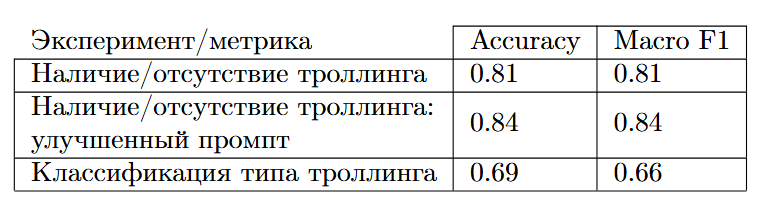